In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
inv = np.linalg.inv
import bio_lda.lda as lda
import bio_lda.util as util

In [2]:
np.random.seed(0)
samples = int(10e3) # Number of samples in dataset
d = 10 # Dimensionality of Data
proportions = [0.5,0.5] # Proportion of samples in classes
X, y, m1, m2, cov = util.generate_dataset(samples, d, proportions)



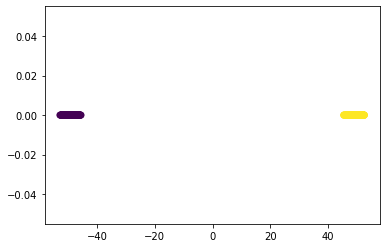

1.0


In [3]:
y_, true_LDA_score, clf = util.scikit_LDA(X, y)
plt.scatter(y_,np.zeros(y_.shape), c = y)
plt.show()
print(true_LDA_score)


In [4]:
def eta(t):
    return 1e-3

def gamma(t):
    return 1e-3

In [5]:
LDA, err, metric, optimal = util.run_offline(X, y, m1, m2, cov, true_LDA_score, eta,gamma,epochs=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1180.88it/s]


In [6]:
# Offline Accuracy
Y = LDA.w.T.dot(X.T)
max((np.sum(Y[:,y == 1] > 1/2 * LDA.w.T@(m1+m2)) + np.sum(Y[:,y == 0] < 1/2 * LDA.w.T@(m1+m2))), (np.sum(Y[:,y == 0] > 1/2 * LDA.w.T@(m1+m2)) + np.sum(Y[:,y == 1] < 1/2 * LDA.w.T@(m1+m2))) )/X.shape[0]

1.0

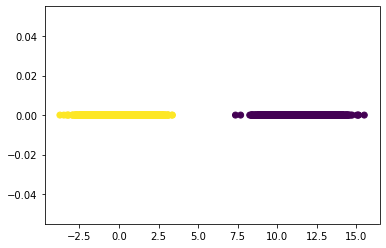

In [7]:
plt.scatter(Y,np.zeros(Y.shape), c = y)
plt.show()

In [8]:
# Optimal Accuracy
optimal_W = np.linalg.inv(cov)@(m1-m2)
Y = optimal_W.T.dot(X.T)
max((np.sum(Y[y == 1] > 1/2 * optimal_W.T@(m1+m2)) + np.sum(Y[y == 0] < 1/2 * optimal_W.T@(m1+m2))), (np.sum(Y[y == 0] > 1/2 * optimal_W.T@(m1+m2)) + np.sum(Y[y == 1] < 1/2 * optimal_W.T@(m1+m2))) )/X.shape[0]

1.0

In [9]:
optimal[-1]

9372.241757540289

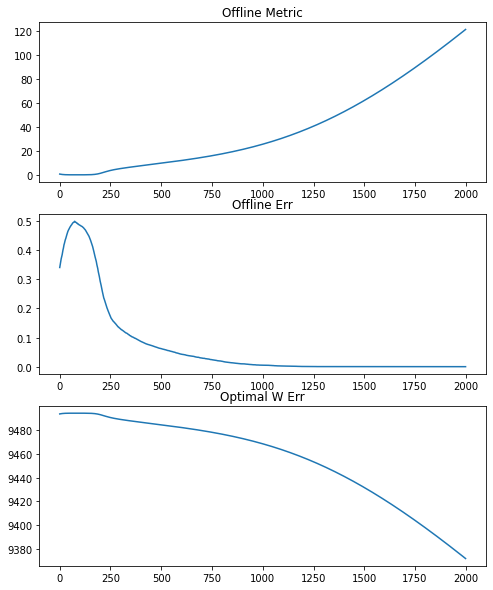

In [10]:
fig, axs = plt.subplots(3,1, figsize=(8,10))

axs[0].plot(metric)
axs[0].set_title("Offline Metric") # Value of W
axs[1].plot(err)
axs[1].set_title("Offline Err") # Accuracy
axs[2].plot(optimal)
axs[2].set_title("Optimal W Err") # Err of W from Optimal W
plt.show()

In [59]:
def eta(t):
    return 1e-4/(t+5)

def gamma(t):
    return 1e-4/(t+5)

In [60]:
LDA, err, metric, optimal = util.run_online(X, y, m1, m2, cov,  true_LDA_score, eta, gamma, epochs=2000)

100%|██████████| 2000/2000 [07:38<00:00,  4.37it/s]


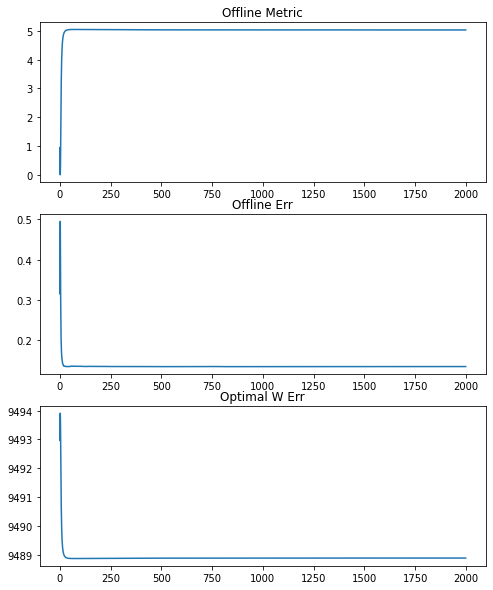

In [61]:
fig, axs = plt.subplots(3,1, figsize=(8,10))

axs[0].plot(metric)
axs[0].set_title("Offline Metric") # Value of W
axs[1].plot(err)
axs[1].set_title("Offline Err") # Accuracy
axs[2].plot(optimal)
axs[2].set_title("Optimal W Err") # Err of W from Optimal W
plt.show()

In [58]:
err[-1]

0.139

In [47]:
# Online Accuracy
Y = LDA.w.T.dot(X.T)
max((np.sum(Y[y == 1] > 1/2 * LDA.w.T@(m1+m2)) + np.sum(Y[y == 0] < 1/2 * LDA.w.T@(m1+m2))), (np.sum(Y[y == 0] > 1/2 * LDA.w.T@(m1+m2)) + np.sum(Y[y == 1] < 1/2 * LDA.w.T@(m1+m2))) )/X.shape[0]

0.8658

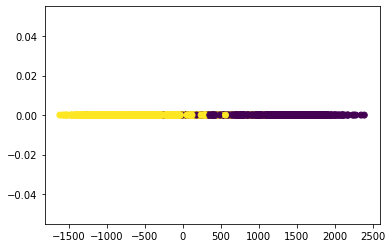

In [48]:
plt.scatter(Y,np.zeros(Y.shape), c = y)
plt.show()